In [7]:
#import libraries needed
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [27]:
#Load the dataset to use 
#data = pd.read_csv(file_path)  
data = pd.read_csv('../Data/reduced_reddit.csv', index_col=False)
print(data.head(10))  # Display the first few rows of the dataframe


   subreddit                                              title  \
0  teenagers                        Day 18 of doing 50 push-ups   
1  teenagers  There isn’t a better feeling than finishing yo...   
2  teenagers  LMAOOO I can only get this guy to talk to me i...   
3  teenagers                       This isn't going to work out   
4  teenagers  Am I the only guy who found it hurtful as a ch...   
5  teenagers                                   Phew , close one   
6  teenagers              Listen to my favorite song part 2 🤩🤩🤩   
7  teenagers                                 Hard core cuddling   
8  teenagers                      Don't communicate with women.   
9  teenagers       Do you guys just ever want to be left alone?   

                                                body  upvotes   created_utc  \
0                                                NaN      4.0  1.619357e+09   
1  Then your teacher hits you with that “ Good jo...      7.0  1.554103e+09   
2                        

In [9]:
#check the dataset information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [10]:
#check on the description of numerical datatypes
data.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


### Data Cleaning

In [11]:
#check to see if there are null values in percentage form
data.isnull().sum() / len(data) * 100

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

In [12]:
# Now you can fill missing values in 'body' column for the new 'data_main'
data['num_comments'] = data['num_comments'].fillna(0)

# Check the DataFrame info again to confirm the change
data.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [13]:
# Verify that there are no more missing values
data.isnull().sum()

subreddit           0
title               0
body            18455
upvotes             0
created_utc         0
num_comments        0
label               0
dtype: int64

In [14]:
# Now you can fill missing values in 'body' column for the new 'data_main'
data['body'] = data['body'].fillna("No content")

# Check the DataFrame info again to confirm the change
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          98826 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [15]:
#check for missing values 
data.isnull().sum()

subreddit       0
title           0
body            0
upvotes         0
created_utc     0
num_comments    0
label           0
dtype: int64

Remove duplicates

In [16]:
# Remove duplicates and assign it back to the dataframe
data =data.drop_duplicates()
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          98826 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 6.0+ MB


In [17]:
# Convert 'created_utc' column from UTC epoch time to datetime
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')

# To see the updated DataFrame

data

,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,No content,4.0,2021-04-25 13:25:39,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,2019-04-01 07:19:57,0.0,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,2022-04-07 14:35:00,12.0,0.0
3,teenagers,This isn't going to work out,No content,236.0,2014-12-03 18:12:52,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,2019-09-23 23:07:59,4.0,0.0
...,...,...,...,...,...,...,...
98821,depression,Has anyone ever had any problems with gangs?,I don't care if my grammer isn't good so dont ...,8.0,2019-05-17 08:30:19,1.0,1.0
98822,SuicideWatch,"Moments away from killing myself, not even bot...","I don't want to talk about my problems, I don'...",12.0,2012-10-20 17:24:21,8.0,1.0
98823,SuicideWatch,I've grown used to being like this for years.,"I'm not suicidal at the moment, in fact I feel...",14.0,2015-05-19 22:19:26,4.0,1.0
98824,depression,This speech from The Lord of the Rings really ...,"""It's like in the great stories, Mr. Frodo. Th...",323.0,2012-12-16 15:44:18,28.0,1.0


## Exploratory Data Analysis

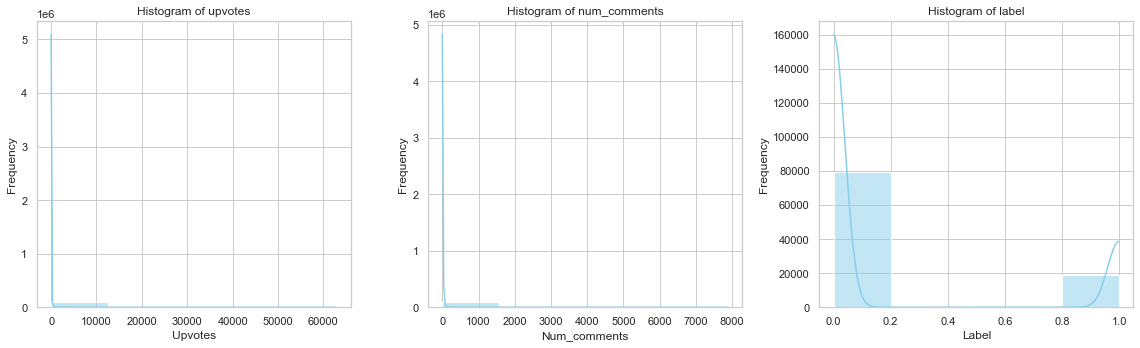

In [18]:
#Visualize the frequency distribution of values using histograms and to identify outliers using the box plots- for upvotes and num_comments

sns.set(style="whitegrid")
numeric_columns = ['upvotes', 'num_comments', 'label']

# Set up the subplot grid
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(16, 5))

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col], bins=5, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

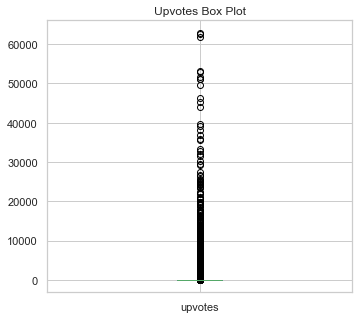

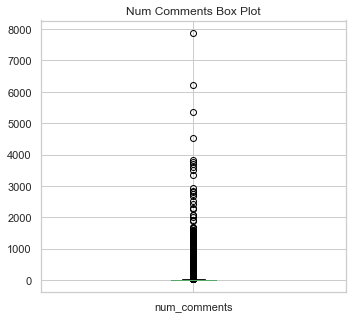

In [19]:
# Upvotes box plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
data['upvotes'].plot(kind='box')
plt.title('Upvotes Box Plot')
plt.show()

#for num_comments
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
data['num_comments'].plot(kind='box')
plt.title('Num Comments Box Plot')
plt.show()

teenagers       78251
depression      11672
SuicideWatch     7544
happy             995
DeepThoughts      364
Name: subreddit, dtype: int64
0.0    79610
1.0    19216
Name: label, dtype: int64


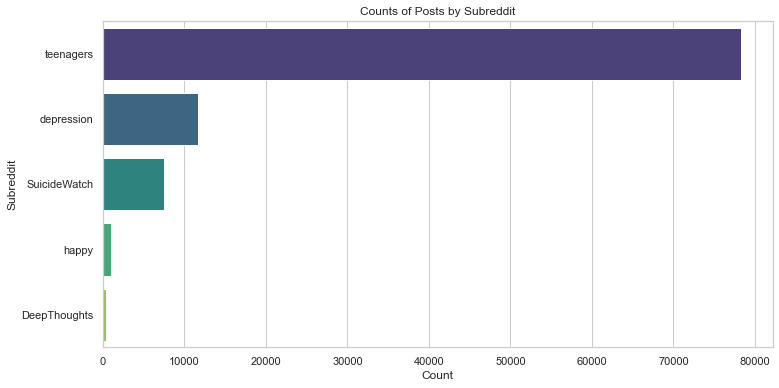

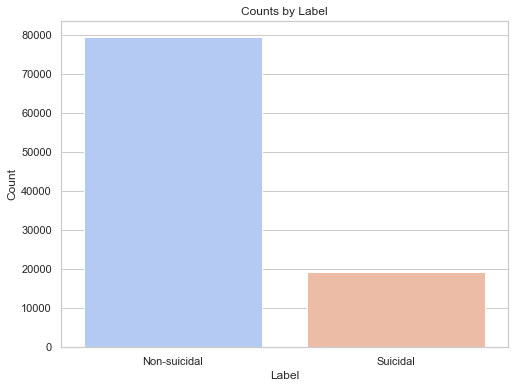

In [20]:
#Frequency of categorical columns

# Frequency of 'subreddit' column
print(data['subreddit'].value_counts())

# Frequency of 'label' column
print(data['label'].value_counts())

# Set style
sns.set(style="whitegrid")

# Plot the counts for 'subreddit' column
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='subreddit', order=data['subreddit'].value_counts().index, palette='viridis')
plt.title('Counts of Posts by Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.show()

# Plot the counts for 'label' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='label', palette='coolwarm')
plt.title('Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-suicidal', 'Suicidal'])
plt.show()



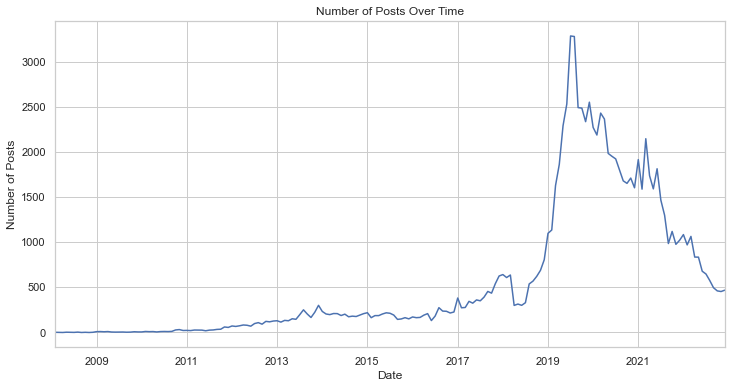

In [21]:
# Plot number of posts over time
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')
data.set_index('created_utc', inplace=True)

# Plot number of posts per month
data.resample('M').size().plot(figsize=(12, 6))
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

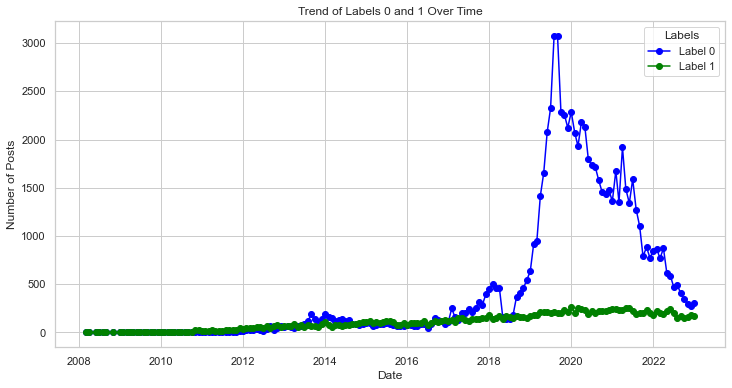

In [22]:
# Resample the data by month (change this to 'W' for weekly or 'D' for daily)
label_trend = data.resample('M')['label'].value_counts().unstack().fillna(0)

# Plot the trend over time for both labels
plt.figure(figsize=(12, 6))
plt.plot(label_trend.index, label_trend[0], label='Label 0', color='blue', marker='o')
plt.plot(label_trend.index, label_trend[1], label='Label 1', color='green', marker='o')

# Adding titles and labels
plt.title('Trend of Labels 0 and 1 Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Labels')
plt.grid(True)

# Show the plot
plt.show()


## Bivariate Analysis

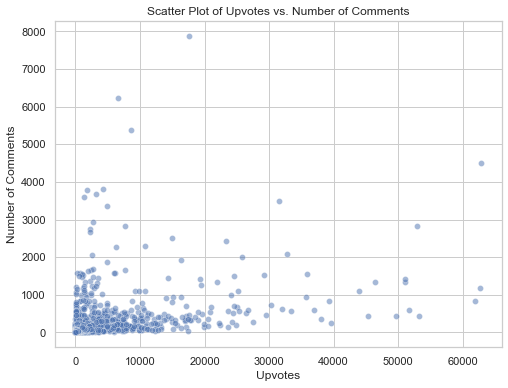

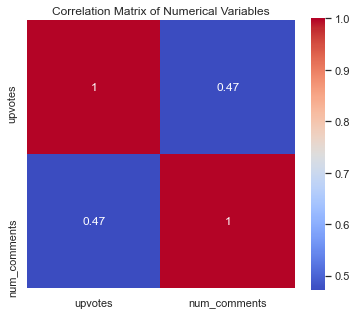

In [23]:
#Numerical vs. Numerical (Scatter plot and correlation matrix)
#Scatter Plot - Shows the relationship between two numerical variables, upvotes and num_comments.

# Scatter plot for numerical variables
plt.figure(figsize=(8, 6))
sns.scatterplot(x='upvotes', y='num_comments', data=data, alpha=0.5)
plt.title("Scatter Plot of Upvotes vs. Number of Comments")
plt.xlabel("Upvotes")
plt.ylabel("Number of Comments")
plt.show()

# Correlation matrix and heatmap
correlation_matrix = data[['upvotes', 'num_comments']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

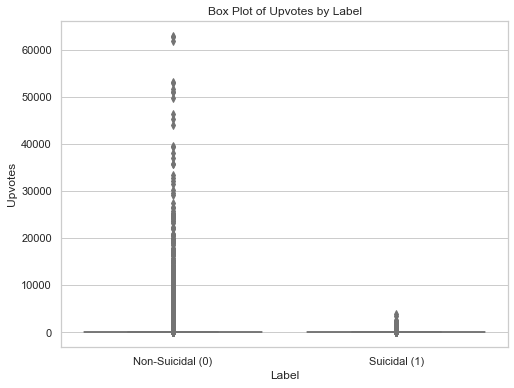

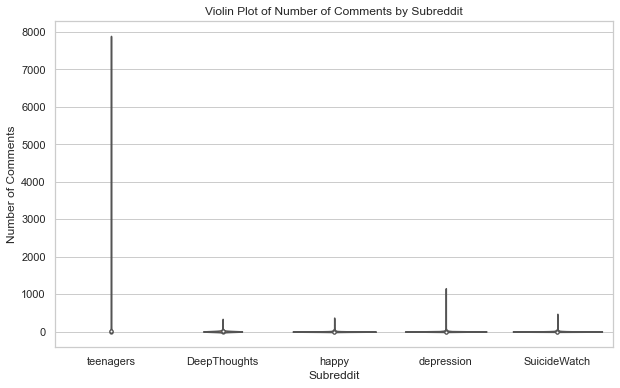

In [24]:
# Numerical vs. Categorical (Box plot and Violin plot)
# Box plot of 'upvotes' by 'label'
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='upvotes', data=data, palette='pastel')
plt.title("Box Plot of Upvotes by Label")
plt.xlabel("Label")
plt.ylabel("Upvotes")
plt.xticks(ticks=[0, 1], labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

# Violin plot of 'num_comments' by 'subreddit'
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='num_comments', data=data, palette='muted')
plt.title("Violin Plot of Number of Comments by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Number of Comments")
plt.show()


Crosstab of Subreddit by Label:
label           0.0    1.0
subreddit                 
DeepThoughts    364      0
SuicideWatch      0   7544
depression        0  11672
happy           995      0
teenagers     78251      0


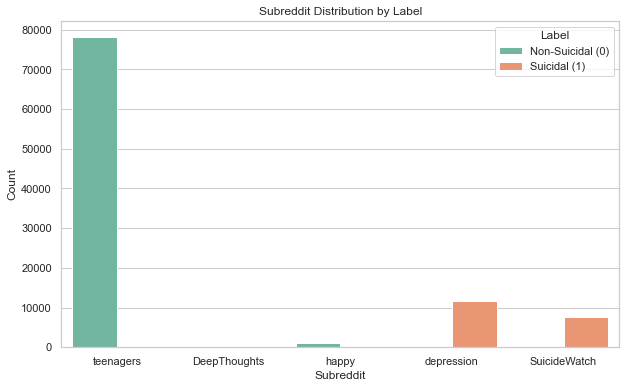

In [25]:
# Crosstab between 'subreddit' and 'label'
crosstab = pd.crosstab(data['subreddit'], data['label'])
print("Crosstab of Subreddit by Label:")
print(crosstab)

# Bar plot for 'subreddit' and 'label'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="subreddit", hue="label", palette="Set2")
plt.title("Subreddit Distribution by Label")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.legend(title="Label", loc='upper right', labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()


## Multivariate analysis

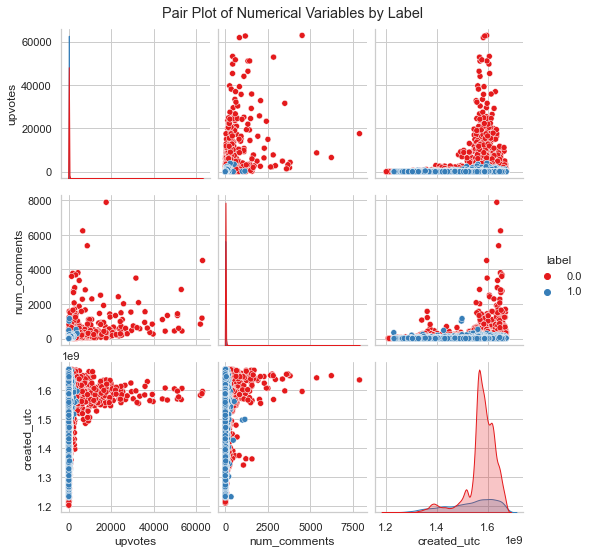

In [28]:
# Pair plot with 'label' as the hue
sns.pairplot(data[['upvotes', 'num_comments', 'created_utc', 'label']], hue='label', palette='Set1', diag_kind='kde')
plt.suptitle("Pair Plot of Numerical Variables by Label", y=1.02)
plt.show()

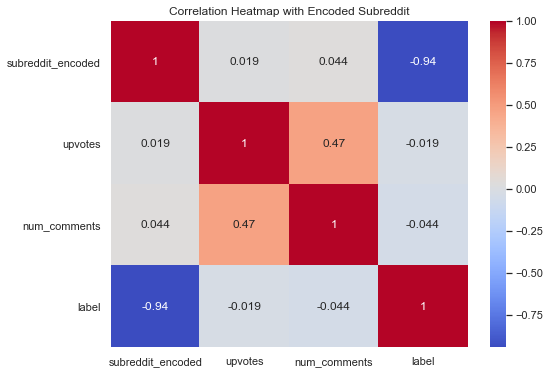

In [ ]:
# Convert the 'subreddit' column to numeric using label encoding
data['subreddit_encoded'] = LabelEncoder().fit_transform(data['subreddit'])

# Now include the encoded 'subreddit' in the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data[['subreddit_encoded', 'upvotes', 'num_comments', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Encoded Subreddit')
plt.show()

## Feature Engineering

In [68]:
# --- 1. Feature Creation ---
# Convert 'created_utc' to datetime format
data['created_utc'] = pd.to_datetime(data['created_utc'])

# Extract year, month, day, hour from 'created_utc'
data['year'] = data['created_utc'].dt.year
data['month'] = data['created_utc'].dt.month
data['day'] = data['created_utc'].dt.day
data['hour'] = data['created_utc'].dt.hour

# Create additional features like ratios or flags
data['upvotes_per_comment'] = data['upvotes'] / (data['num_comments'] + 1)  # Adding 1 to avoid division by zero
data['has_body'] = data['body'].apply(lambda x: 0 if x == 'No content' else 1)  # Flag indicating if there's content in 'body'



# Remove the subreddit encoded columns to improve model generalization
data = data.drop(columns=["subreddit_SuicideWatch", "subreddit_depression", "subreddit_happy", "subreddit_teenagers"])


# --- 3. Scaling and Normalization ---
# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply Standard Scaling on numerical features
data[['upvotes', 'num_comments', 'upvotes_per_comment']] = standard_scaler.fit_transform(
    data[['upvotes', 'num_comments', 'upvotes_per_comment']]
)

# Apply Min-Max Scaling on year, month, day, hour (optional)
data[['year', 'month', 'day', 'hour']] = minmax_scaler.fit_transform(
    data[['year', 'month', 'day', 'hour']]
)

# Display the final DataFrame
data

,title,body,upvotes,created_utc,num_comments,label,processed_title,processed_body,cluster,combined_text,year,month,day,hour,upvotes_per_comment,has_body
0,Day 18 of doing 50 push-ups,NaN,-0.062214,1970-01-01 00:00:01.619357139,-0.156580,0.0,day 18 50 pushup,,0,Day 18 of doing 50 push-ups,0.0,0.0,0.0,0.0,-0.149954,1
1,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,-0.059013,1970-01-01 00:00:01.554103197,NaN,0.0,’ better feeling finishing science paper 1am d...,teacher hit “ good job everyone draft final co...,0,There isn’t a better feeling than finishing yo...,0.0,0.0,0.0,0.0,NaN,1
2,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,-0.062214,1970-01-01 00:00:01.649342100,-0.044907,0.0,lmaooo get guy talk talk god💖💖,yeahhh maybe babe,0,LMAOOO I can only get this guy to talk to me i...,0.0,0.0,0.0,0.0,-0.108513,1
3,This isn't going to work out,NaN,0.185294,1970-01-01 00:00:01.417630372,0.248234,0.0,isnt going work,,0,This isn't going to work out,0.0,0.0,0.0,0.0,0.917743,1
4,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,-0.060080,1970-01-01 00:00:01.569280079,-0.156580,0.0,guy found hurtful child movie kid female chara...,like funny deserve better male character kick ...,0,Am I the only guy who found it hurtful as a ch...,0.0,0.0,0.0,0.0,-0.137799,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98821,Has anyone ever had any problems with gangs?,I don't care if my grammer isn't good so dont ...,-0.057946,1970-01-01 00:00:01.558081819,-0.198458,1.0,anyone ever problem gang,dont care grammer isnt good dont even bring se...,3,Has anyone ever had any problems with gangs? I...,0.0,0.0,0.0,0.0,-0.142890,1
98822,"Moments away from killing myself, not even bot...","I don't want to talk about my problems, I don'...",-0.053679,1970-01-01 00:00:01.350753861,-0.100744,1.0,moment away killing even bothering make throw ...,dont want talk problem dont want talk problem ...,1,"Moments away from killing myself, not even bot...",0.0,0.0,0.0,0.0,-0.082344,1
98823,I've grown used to being like this for years.,"I'm not suicidal at the moment, in fact I feel...",-0.051545,1970-01-01 00:00:01.432073966,-0.156580,1.0,ive grown used like year,im suicidal moment fact feel great right time ...,3,I've grown used to being like this for years. ...,0.0,0.0,0.0,0.0,-0.089177,1
98824,This speech from The Lord of the Rings really ...,"""It's like in the great stories, Mr. Frodo. Th...",0.278110,1970-01-01 00:00:01.355672658,0.178438,1.0,speech lord ring really inspires go,like great story mr frodo one really mattered ...,3,This speech from The Lord of the Rings really ...,0.0,0.0,0.0,0.0,1.338431,1


### Natural Language Preprocessing

#### Text preprocessing

In [59]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator
import string# Download necessary NLTK resources

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stopwords, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#define a class TextPreprocessor that conforms to scikit-learn’s transformer API
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting required for this transformer

    def transform(self, X, y=None):
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        if pd.isnull(text):
            return ''  # Return empty string for missing values
        text = text.lower()  # Lowercase
        text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
        return ' '.join(tokens)  # Join tokens back into string


# Instantiate TextPreprocessor
text_preprocessor = TextPreprocessor()

# Apply the text preprocessor to 'title' and 'body' columns
data['processed_title'] = text_preprocessor.transform(data['title'])
data['processed_body'] = text_preprocessor.transform(data['body'])

# Display the processed data
data[['processed_title', 'processed_body']]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,processed_title,processed_body
0,day 18 50 pushup,
1,’ better feeling finishing science paper 1am d...,teacher hit “ good job everyone draft final co...
2,lmaooo get guy talk talk god💖💖,yeahhh maybe babe
3,isnt going work,
4,guy found hurtful child movie kid female chara...,like funny deserve better male character kick ...
...,...,...
98821,anyone ever problem gang,dont care grammer isnt good dont even bring se...
98822,moment away killing even bothering make throw ...,dont want talk problem dont want talk problem ...
98823,ive grown used like year,im suicidal moment fact feel great right time ...
98824,speech lord ring really inspires go,like great story mr frodo one really mattered ...


 ### Feature Extraction 
 Produces a different type of numerical representation of the text data, enabling us to use it as input for machine learning models.
 
 We will use TF-IDF as it weighs words by their frequency in a document relative to their frequency across all documents.

 It allows to leverage the importance of unique words within each post and balances the contribution of frequent words, making it well-suited for distinguishing between subreddits or post types.

 starting with TF-IDF and evaluate its performance. If the results aren’t satisfactory, we will consider experimenting with word embeddings for potential improvements.

In [60]:
# TF-IDF -give higher weights to words that are less common across documents.
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import pandas as pd

# Apply TF-IDF to the title and body columns separately
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # limit to top 10,000 features_to manage vocabulary size


# Use the processed title and body columns 
tfidf_title = tfidf_vectorizer.fit_transform(data['processed_title'])
tfidf_body = tfidf_vectorizer.fit_transform(data['processed_body'])

# You can keep these as sparse matrices or concatenate directly if needed for model input
combined_features = csr_matrix(tfidf_title) + csr_matrix(tfidf_body) # in sparse format, to save memory



Here we have feature reduction where I will be working with the top 10,000 - retaining the most relevant words, reducing noise and memory load. 

If I use all features, I get a memory error indicating that the conversion of the TF-IDF sparse matrix to a dense format (.toarray()) is exceeding your available memory, likely due to the large number of documents and vocabulary size. 

Hence the Sparse Matrix Size: The resulting TF-IDF matrix will have a maximum of 10,000 columns (features), significantly reducing memory requirements when compared to the full vocabulary size.



This compromise allows us to handle large datasets while retaining a high level of detail in the features for training your model.

### Exploratory Data Analysis 
EDA on the processed text data with the reduced features


In [53]:

#Examine the top words by TF-IDF Scores

# Display the top terms with the highest TF-IDF scores
tfidf_sum = combined_features.sum(axis=0)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame({'term': feature_names, 'tfidf_score': tfidf_sum.A1})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Display the top 20 terms with the highest TF-IDF scores
tfidf_df.head(50)


,term,tfidf_score
4558,im,2951.154806
9640,want,2920.344788
5264,like,2674.925609
4540,ie,1887.889586
2835,dont,1867.329365
5082,know,1829.199974
3500,feel,1785.575874
3924,get,1679.820679
6165,one,1572.184302
5247,life,1482.131980


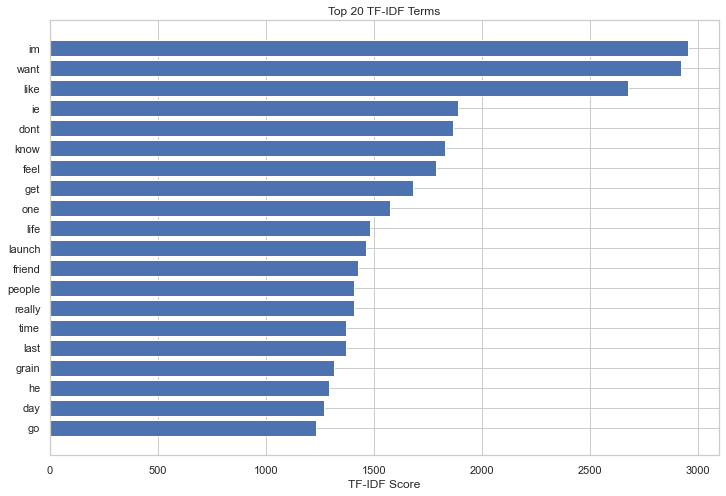

In [54]:
# Visualize the Top TF-IDF Terms

# Bar plot of the top 20 terms
plt.figure(figsize=(12, 8))
plt.barh(tfidf_df['term'].head(20), tfidf_df['tfidf_score'].head(20))
plt.xlabel("TF-IDF Score")
plt.title("Top 20 TF-IDF Terms")
plt.gca().invert_yaxis()
plt.show()

In [57]:
# Calculate density (fraction of non-zero elements)
density_title = tfidf_title.nnz / (tfidf_title.shape[0] * tfidf_title.shape[1])
density_body = tfidf_body.nnz / (tfidf_body.shape[0] * tfidf_body.shape[1])
print(f"Density of TF-IDF matrix for title: {density_title:.4f}")
print(f"Density of TF-IDF matrix for body: {density_body:.4f}")


Density of TF-IDF matrix for title: 0.0005
Density of TF-IDF matrix for body: 0.0025


Cluster Analysis on Combined TF-IDF Matrix (Optional)
Use clustering techniques (e.g., KMeans) to identify patterns or groupings in your data.

In [58]:
from sklearn.cluster import KMeans

# Define number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(combined_features)

# Add the cluster labels to the original dataset for further analysis
data['cluster'] = clusters
print(data[['title', 'body', 'cluster']].head())


                                               title  \
0                        Day 18 of doing 50 push-ups   
1  There isn’t a better feeling than finishing yo...   
2  LMAOOO I can only get this guy to talk to me i...   
3                       This isn't going to work out   
4  Am I the only guy who found it hurtful as a ch...   

                                                body  cluster  
0                                                NaN        0  
1  Then your teacher hits you with that “ Good jo...        0  
2                              Yeahhh maybe not babe        0  
3                                                NaN        0  
4   \n\nLike... why? How is that funny? How does ...        0  


### Model Selection and Training

In [69]:
#Select and train a model using features extracted in the previous step.
# Model 1 - Baseline Model 
#Logistic Regression 

#Model 2 - Naive Bayes 

#Model 3 - SVM 

#Deep Learning BERT

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

# Define the numerical and text features
numerical_features = ['upvotes', 'num_comments', 'year', 'month', 'day', 'hour', 'upvotes_per_comment', 'has_body']


# Define a transformer for scaling numerical features
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=10000), 'combined_text'),  # Text processing
    ('num', StandardScaler(), ['upvotes', 'num_comments', 'upvotes_per_comment'])  # Scaling numerical columns
])

# For numerical features, we will impute missing values and then scale
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values (mean strategy)
    ('scaler', StandardScaler())  # Scale numerical features
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('text', text_transformer, 'combined_text'),  # Apply text preprocessing to combined text
    ('numerical', numerical_transformer, numerical_features),  # Apply numerical transformations    
])

# Define the full pipeline with preprocessor and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga', max_iter=200))  # You can switch this with any classifier
])

# Combine the title and body text into one column
data['combined_text'] = data['title'].fillna('') + ' ' + data['body'].fillna('')

# Set up features (X) and target (y)
X = data[['combined_text'] + numerical_features ]  # Include text and numerical features
y = data['label']  # Replace 'label' with the actual target column name

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predictions on the training set
train_predictions = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)

# Predictions on the testing set
test_predictions = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Testing Accuracy:", test_accuracy)



c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training Accuracy: 0.9165064507968631
Testing Accuracy: 0.9203683092178488


Iteration II - without the numerical features - just the body and labels


In [70]:


# Define a transformer for scaling numerical features
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=10000), 'combined_text'),  # Text processing    
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('text', text_transformer, 'combined_text'),  # Apply text preprocessing to combined text
    ])

# Define the full pipeline with preprocessor and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga', max_iter=200))  # You can switch this with any classifier
])

# Combine the title and body text into one column
data['combined_text'] = data['title'].fillna('') + ' ' + data['body'].fillna('')

# Set up features (X) and target (y)
X = data[['combined_text']]  # Include text and numerical features
y = data['label']  # Replace 'label' with the actual target column name

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predictions on the training set
train_predictions = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)

# Predictions on the testing set
test_predictions = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Testing Accuracy:", test_accuracy)


Training Accuracy: 0.9407918036933974
Testing Accuracy: 0.935950622280684


In [ ]:
#Model 2 - Naive Bayes 

#Model 3 - SVM 

#Deep Learning BERT

5. Model Evaluation
Evaluate your model using appropriate metrics.

Accuracy: Useful for balanced datasets.
Precision, Recall, F1-Score: Useful for imbalanced datasets.
python
Copy code
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

6. Tuning and Optimization
Hyperparameter Tuning: Use Grid Search or Random Search to optimize parameters.
Cross-Validation: Ensure your model generalizes well.

7. Deployment and Monitoring
Deploy the model to a web application or API.
Monitor model performance over time and update as necessary.